In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

Files already downloaded and verified


In [3]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.2, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

torch.Size([128, 3, 32, 32])
tensor(11)


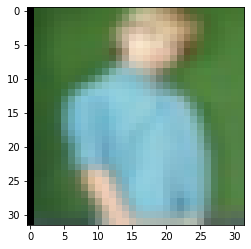

In [5]:
import matplotlib.pyplot as plt

for img, lbl in train_loader:
    print(img.shape)
    print(lbl[0])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 16, 3, padding=1)
        self.bn_two = torch.nn.BatchNorm2d(16) 
        self.conv_two = torch.nn.Conv2d(16, 32, 3, padding=1)
        self.bn_three = torch.nn.BatchNorm2d(32)
        self.conv_three = torch.nn.Conv2d(32, 64, 3, padding=1)
        self.bn_four = torch.nn.BatchNorm2d(64)
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.out = torch.nn.Linear(256, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_two): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_three): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn_four): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=100, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [9]:
from torchsummary import summary

summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 16, 32, 32]             448
       BatchNorm2d-3           [-1, 16, 16, 16]              32
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5             [-1, 32, 8, 8]              64
            Conv2d-6             [-1, 64, 8, 8]          18,496
       BatchNorm2d-7             [-1, 64, 4, 4]             128
           Dropout-8                 [-1, 1024]               0
            Linear-9                  [-1, 512]         524,800
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
           Linear-12                  [-1, 100]          25,700
Total params: 705,642
Trainable params: 705,642
Non-trainable params: 0
-------------------------------

In [10]:
num_epochs = 5
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/313]. Loss: 0.036. Acc: 0.016. Test acc: 0.010
Epoch [1/5]. Step [301/313]. Loss: 0.032. Acc: 0.071. Test acc: 0.094
Epoch [2/5]. Step [1/313]. Loss: 0.029. Acc: 0.125. Test acc: 0.107
Epoch [2/5]. Step [301/313]. Loss: 0.029. Acc: 0.113. Test acc: 0.138
Epoch [3/5]. Step [1/313]. Loss: 0.029. Acc: 0.117. Test acc: 0.134
Epoch [3/5]. Step [301/313]. Loss: 0.028. Acc: 0.145. Test acc: 0.161
Epoch [4/5]. Step [1/313]. Loss: 0.025. Acc: 0.195. Test acc: 0.143
Epoch [4/5]. Step [301/313]. Loss: 0.027. Acc: 0.172. Test acc: 0.185
Epoch [5/5]. Step [1/313]. Loss: 0.027. Acc: 0.188. Test acc: 0.178
Epoch [5/5]. Step [301/313]. Loss: 0.026. Acc: 0.191. Test acc: 0.176
Training is finished!


## Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [42]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
from torchsummary import summary
summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [44]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [45]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [46]:
resnet50 = resnet50.to(device)

In [47]:
train_actions = transforms.Compose([
                                    # transforms.Resize(40),
                                    # transforms.RandomCrop(32, padding=2), 
                                   transforms.Resize(256),
                                   transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225]),
                                    ])
valid_transforms = transforms.Compose([
                                      transforms.Resize(224),
                                      #  transforms.Resize(32),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225]),
                                       ])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [48]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [49]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.005)
criterion = nn.CrossEntropyLoss()

In [50]:
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/313]. Loss: 0.036. Acc: 0.008. Test acc: 0.013
Epoch [1/5]. Step [301/313]. Loss: 0.020. Acc: 0.399. Test acc: 0.495
Epoch [2/5]. Step [1/313]. Loss: 0.017. Acc: 0.492. Test acc: 0.487
Epoch [2/5]. Step [301/313]. Loss: 0.016. Acc: 0.496. Test acc: 0.527
Epoch [3/5]. Step [1/313]. Loss: 0.017. Acc: 0.445. Test acc: 0.510
Epoch [3/5]. Step [301/313]. Loss: 0.016. Acc: 0.517. Test acc: 0.519
Epoch [4/5]. Step [1/313]. Loss: 0.014. Acc: 0.578. Test acc: 0.541
Epoch [4/5]. Step [301/313]. Loss: 0.016. Acc: 0.528. Test acc: 0.530
Epoch [5/5]. Step [1/313]. Loss: 0.017. Acc: 0.477. Test acc: 0.520
Epoch [5/5]. Step [301/313]. Loss: 0.016. Acc: 0.542. Test acc: 0.536
Training is finished!


когда делаю
- transforms.Resize(256),
- transforms.RandomCrop(224, padding=4), 

то метрики вырастают до 0,536

это вообще нелогично - картинки 32х32 и я их увеличиваю до 256х256, а метрика высокая ...

если убираю resize,  то получаю низкие метрики

Epoch [1/5]. Step [1/313]. Loss: 0.037. Acc: 0.000. Test acc: 0.018

Epoch [1/5]. Step [301/313]. Loss: 0.035. Acc: 0.184. Test acc: 0.212

Epoch [2/5]. Step [1/313]. Loss: 0.028. Acc: 0.266. Test acc: 0.222

Epoch [2/5]. Step [301/313]. Loss: 0.031. Acc: 0.257. Test acc: 0.238

Epoch [3/5]. Step [1/313]. Loss: 0.029. Acc: 0.273. Test acc: 0.233

Epoch [3/5]. Step [301/313]. Loss: 0.030. Acc: 0.288. Test acc: 0.249

Epoch [4/5]. Step [1/313]. Loss: 0.024. Acc: 0.352. Test acc: 0.247

Epoch [4/5]. Step [301/313]. Loss: 0.028. Acc: 0.310. Test acc: 0.245

Epoch [5/5]. Step [1/313]. Loss: 0.023. Acc: 0.336. Test acc: 0.246

Epoch [5/5]. Step [301/313]. Loss: 0.028. Acc: 0.327. Test acc: 0.252
Training is finished!

## *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [51]:
resnet50 = models.resnet50(pretrained=True)

for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

resnet50.fc = nn.Linear(2048, 100)

resnet50 = resnet50.to(device)

In [52]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.005)
criterion = nn.CrossEntropyLoss()

In [53]:
trans_actions = transforms.Compose([
                                    # transforms.Resize(size=(40, 40), ),
                                    # transforms.RandomRotation(degrees=(90)),
                                    transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.RandomGrayscale(0.3),
                                    transforms.ColorJitter(brightness=2, contrast=2),
                                    # transforms.CenterCrop(size=32),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225]),
                                    ])

valid_transforms = transforms.Compose([
                                       transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225]),])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=2)

In [54]:
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/313]. Loss: 0.036. Acc: 0.016. Test acc: 0.006
Epoch [1/5]. Step [301/313]. Loss: 0.033. Acc: 0.157. Test acc: 0.402
Epoch [2/5]. Step [1/313]. Loss: 0.029. Acc: 0.211. Test acc: 0.410
Epoch [2/5]. Step [301/313]. Loss: 0.029. Acc: 0.218. Test acc: 0.414
Epoch [3/5]. Step [1/313]. Loss: 0.031. Acc: 0.156. Test acc: 0.426
Epoch [3/5]. Step [301/313]. Loss: 0.029. Acc: 0.233. Test acc: 0.478
Epoch [4/5]. Step [1/313]. Loss: 0.028. Acc: 0.266. Test acc: 0.432
Epoch [4/5]. Step [301/313]. Loss: 0.029. Acc: 0.240. Test acc: 0.441
Epoch [5/5]. Step [1/313]. Loss: 0.028. Acc: 0.258. Test acc: 0.458
Epoch [5/5]. Step [301/313]. Loss: 0.028. Acc: 0.249. Test acc: 0.456
Training is finished!


Аугментация не помогла сетке поднять метрики, возможно надо поиграться с параметрами аугментации и разобраться с Resize - в чем причина увеличения метрик на претренированной модели на прошлом этапе.